In [ ]:
# alarm sequence segmentation
# removing chattering alarms
# SNGS word embedding

# alarm definition nasıl olmalı?

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [21]:
data_path = "data/final-all-months-alarms-with-day-filtered.csv"
df = pd.read_csv(data_path)

In [3]:
df.head()

,MachineName,SourceName,Message,Condition,MessageType,StartTime,EndTime,EndMessage,TimeDelta,Year-Month,Day
0,PHD47B,48TIC2026,48TIC2026 E208 CKS TEMIZ MDEA PV = -4.5 C VEL-,VEL-,Activation,2020-03-01 00:00:03,2020-03-01 00:00:05,48TIC2026 E208 CKS TEMIZ MDEA PV = -4.3 C VEL-...,2.0,"(2020, 3)",1
1,PHD47B,48TIC2026,48TIC2026 E208 CKS TEMIZ MDEA PV = -4.8 C VEL-,VEL-,Activation,2020-03-01 00:00:07,2020-03-01 00:00:08,48TIC2026 E208 CKS TEMIZ MDEA PV = -4.4 C VEL-...,1.0,"(2020, 3)",1
2,PHD47B,48TIC2026,48TIC2026 E208 CKS TEMIZ MDEA PV = -4.9 C VEL-,VEL-,Activation,2020-03-01 00:00:10,2020-03-01 00:00:11,48TIC2026 E208 CKS TEMIZ MDEA PV = -4.6 C VEL-...,1.0,"(2020, 3)",1
3,PHD47B,48TIC2026,48TIC2026 E208 CKS TEMIZ MDEA PV = -4.5 C VEL-,VEL-,Activation,2020-03-01 00:00:18,2020-03-01 00:00:20,48TIC2026 E208 CKS TEMIZ MDEA PV = -4.2 C VEL-...,2.0,"(2020, 3)",1
4,PHD47B,48TIC2026,48TIC2026 E208 CKS TEMIZ MDEA PV = -4.6 C VEL-,VEL-,Activation,2020-03-01 00:00:22,2020-03-01 00:00:23,48TIC2026 E208 CKS TEMIZ MDEA PV = -4.2 C VEL-...,1.0,"(2020, 3)",1


In [4]:
df["Year-Month"].value_counts() # there are 13 months

(2019, 10)    1350604
(2020, 1)     1283309
(2019, 12)    1229221
(2019, 11)    1187442
(2020, 2)     1050337
(2019, 7)     1021617
(2019, 9)      921157
(2019, 8)      889120
(2019, 5)      882724
(2019, 6)      847634
(2020, 3)      691967
(2019, 4)      579504
(2019, 3)      287664
Name: Year-Month, dtype: int64

In [22]:
# sort the data with StartTime
df["StartTime"] = pd.to_datetime(df["StartTime"])
df = df.sort_values(by = "StartTime")
df = df.reset_index(drop=True) # reset index

In [16]:
df["StartTime"].head(20)

0    2019-03-06 13:19:00
1    2019-03-06 13:19:00
2    2019-03-06 13:19:17
3    2019-03-06 13:19:24
4    2019-03-06 13:19:24
5    2019-03-06 13:19:35
6    2019-03-06 13:19:35
7    2019-03-06 13:19:35
8    2019-03-06 13:19:38
9    2019-03-06 13:19:38
10   2019-03-06 13:19:47
11   2019-03-06 13:19:47
12   2019-03-06 13:19:58
13   2019-03-06 13:19:58
14   2019-03-06 13:20:12
15   2019-03-06 13:20:12
16   2019-03-06 13:20:15
17   2019-03-06 13:20:15
18   2019-03-06 13:20:24
19   2019-03-06 13:20:27
Name: StartTime, dtype: datetime64[ns]

In [17]:
df["StartTime"].value_counts() # there are alarms with same start time so be careful about this

2019-05-13 14:29:19    22
2019-12-27 14:10:22    20
2019-10-17 14:40:34    17
2019-10-17 09:31:00    17
2019-10-17 14:41:36    16
                       ..
2019-05-13 07:08:07     1
2019-09-14 18:24:22     1
2019-09-14 18:24:17     1
2019-09-14 18:24:15     1
2020-03-22 10:40:51     1
Name: StartTime, Length: 10501515, dtype: int64

In [18]:
# lets check it
print(df["StartTime"].iloc[0]) # the number in iloc is the index
print(df["StartTime"].iloc[-1]) # this is like 1 year dataset

2019-03-06 13:19:00
2020-03-22 10:40:51


## Choose the alarm definition. It is subject to change. They are gonna be embedded anyway.

- I decided to play with the Message column to create alarms. Since the PV value differs too much, I select the values until you see the PV characters. Now there are around 1122 unique alarms in this dataset if you define the alarms like this.

In [19]:
df["Message"].value_counts() # 22090 unique message values

47TI931A C5 1.YTK GIRDISCAP SICAK PV = 691 C IOP    3285339
48TIC2026 E208 CKS TEMIZ MDEA PV = -4.2 C VEL+       363833
48TIC2026 E208 CKS TEMIZ MDEA PV = -4.1 C VEL+       362033
48TIC2026 E208 CKS TEMIZ MDEA PV = -4.0 C VEL+       352286
48TIC2026 E208 CKS TEMIZ MDEA PV = -4.3 C VEL+       318274
                                                     ...   
47PI1734 PV = 6.41 Kg/cm2 HI                              1
47PI1734 PV = 6.41 Kg/cm2 HH                              1
47PI1734 PV = 5.01 Kg/cm2 HI                              1
47LI024 C-7 YENI SEVIYE PV = 41.6 % IOP                   1
47LIC1555 D-107 SEVIYE PV = 35.0 % LL                     1
Name: Message, Length: 22090, dtype: int64

In [23]:
def extract_text_before_pv(message):
    text_before_pv = message.split("PV")[0].strip()
    return text_before_pv

def extract_SourceName_and_Identifier(message):
    source_name = message.split(" ")[0].strip()
    identifier = message.split(" ")[-1].strip()
    return source_name + " " + identifier

def all_values_except_PV(message): # text before PV and text after value
    text_before_pv = message.split(" PV ")[0].strip() # text before PV: all information.
    text_after_value = message.split(" ")[-1].strip() # identifier
    return text_before_pv + " " + text_after_value

df['Text_Before_PV'] = df['Message'].apply(extract_text_before_pv)
df['SourceName_Identifier'] = df['Message'].apply(extract_SourceName_and_Identifier)
df['All_Values_Except_PV'] = df['Message'].apply(all_values_except_PV)

In [24]:
df[["Text_Before_PV", "SourceName_Identifier", "All_Values_Except_PV"]].head()
# some PV values are not removed. Fix it later. It is because you use " PV " instead of "PV". Some are missing PV.

,Text_Before_PV,SourceName_Identifier,All_Values_Except_PV
0,48TIC2027 E209 CIKIS REJEN DRAM,48TIC2027 IOP-,48TIC2027 E209 CIKIS REJEN DRAM IOP-
1,48FIX2040 C206'DAN C4'E A.GAZ C,48FIX2040 IOP-,48FIX2040 C206'DAN C4'E A.GAZ CPV = -1 m3/h IO...
2,47TI931A C5 1.YTK GIRDISCAP SICAK,47TI931A IOP,47TI931A C5 1.YTK GIRDISCAP SICAK IOP
3,48TIC2027 E209 CIKIS REJEN DRAM,48TIC2027 IOP-,48TIC2027 E209 CIKIS REJEN DRAM IOP-
4,48FIX2040 C206'DAN C4'E A.GAZ C,48FIX2040 IOP-,48FIX2040 C206'DAN C4'E A.GAZ CPV = -1 m3/h IO...


In [11]:
df['Text_Before_PV'].value_counts() # 1122 unique values

48TIC2026 E208 CKS TEMIZ MDEA                 7162318
47TI931A C5 1.YTK GIRDISCAP SICAK             3285339
47FLI-032 C-109 MERDIV                         294110
48PAL007-ANN INS. DÃÂS Y. HAVASI BAS ALM     169438
47TI003A G-3 GOVDE SICAKLIGI                   124473
                                               ...   
47HID-019H-A K-2C YANI H2 YUK ALM                   1
47FD-023HH-A K2C KURE VANA ALEVYUKYUK ALM           1
47FD-023H-AN K2C KURE VANA ALEV YUK ALM             1
47HSD-025HH- K2B/C PLAT H2S YUK YUK ALM             1
47TI860 DISLI SISTEMYTK SICAK.                      1
Name: Text_Before_PV, Length: 1122, dtype: int64

In [22]:
df['SourceName_Identifier'].value_counts() # 1982 unique values, interesting that there are more unique values than text before PV

48TIC2026 VEL+      3780215
48TIC2026 VEL-      3382103
47TI931A IOP        3285339
48PAL007-ANN ALM     250472
47FLI-032 CNF        147028
                     ...   
47AAH010-ANN ALM          1
48AAH009-ANN ALM          1
48AAH2005-AN ALM          1
48AAH2006-AN ALM          1
47FLI-013 CNF             1
Name: SourceName_Identifier, Length: 1982, dtype: int64

In [26]:
df['All_Values_Except_PV'].value_counts() # 2540 unique values

48TIC2026 E208 CKS TEMIZ MDEA VEL+                    3780215
48TIC2026 E208 CKS TEMIZ MDEA VEL-                    3382103
47TI931A C5 1.YTK GIRDISCAP SICAK IOP                 3285339
48PAL007-ANN INS. DÃÂS Y. HAVASI BAS ALM ALM         169438
47FLI-032 C-109 MERDIVPV-1504 CNF                      147028
                                                       ...   
47PI706 47K-2 SOG SU PUMP BASINC LTRP                       1
47PI706 47K-2 SOG SU PUMP BASINC LLL                        1
47PAL706-ANN G-17 A/B CIKIS ALM ALM                         1
47FI047 47E-8'E PLT-63 KSS CPV = -0.6 m3/h IOP IOP          1
47FLI-013 47C-204 USTU CNF                                  1
Name: All_Values_Except_PV, Length: 2540, dtype: int64

In [25]:
df_alarm = df[["Text_Before_PV", "SourceName_Identifier", "All_Values_Except_PV", "StartTime", "EndTime", "TimeDelta"]]
df_alarm.head()

,Text_Before_PV,SourceName_Identifier,All_Values_Except_PV,StartTime,EndTime,TimeDelta
0,48TIC2027 E209 CIKIS REJEN DRAM,48TIC2027 IOP-,48TIC2027 E209 CIKIS REJEN DRAM IOP-,2019-03-06 13:19:00,2019-03-06 13:19:02,2.0
1,48FIX2040 C206'DAN C4'E A.GAZ C,48FIX2040 IOP-,48FIX2040 C206'DAN C4'E A.GAZ CPV = -1 m3/h IO...,2019-03-06 13:19:00,2019-03-06 13:19:02,2.0
2,47TI931A C5 1.YTK GIRDISCAP SICAK,47TI931A IOP,47TI931A C5 1.YTK GIRDISCAP SICAK IOP,2019-03-06 13:19:17,2019-03-06 13:19:33,16.0
3,48TIC2027 E209 CIKIS REJEN DRAM,48TIC2027 IOP-,48TIC2027 E209 CIKIS REJEN DRAM IOP-,2019-03-06 13:19:24,2019-03-06 13:19:26,2.0
4,48FIX2040 C206'DAN C4'E A.GAZ C,48FIX2040 IOP-,48FIX2040 C206'DAN C4'E A.GAZ CPV = -1 m3/h IO...,2019-03-06 13:19:24,2019-03-06 13:19:26,2.0


In [28]:
# check the time 
print(df_alarm["EndTime"].iloc[0])  # '2020-03-01 00:00:05'
print(df_alarm["EndTime"].iloc[-1]) 

2019-03-06 13:19:02
2020-03-22 10:40:53


## According to the paper, SourceName_Identifier is used as an alarm definition.

In [26]:
# Convert the 'Timestamp' column to a Pandas datetime format
df_alarm['StartTime'] = pd.to_datetime(df['StartTime'])
df_alarm['EndTime'] = pd.to_datetime(df['EndTime'])
print(df_alarm["StartTime"].head())
print(df_alarm["EndTime"].head())

/var/folders/34/1qrznjy966vdc3s1xrx1qb500000gn/T/ipykernel_6610/4056602640.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alarm['StartTime'] = pd.to_datetime(df['StartTime'])


0   2019-03-06 13:19:00
1   2019-03-06 13:19:00
2   2019-03-06 13:19:17
3   2019-03-06 13:19:24
4   2019-03-06 13:19:24
Name: StartTime, dtype: datetime64[ns]
0   2019-03-06 13:19:02
1   2019-03-06 13:19:02
2   2019-03-06 13:19:33
3   2019-03-06 13:19:26
4   2019-03-06 13:19:26
Name: EndTime, dtype: datetime64[ns]


/var/folders/34/1qrznjy966vdc3s1xrx1qb500000gn/T/ipykernel_6610/4056602640.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alarm['EndTime'] = pd.to_datetime(df['EndTime'])


In [10]:
df_alarm["TimeDelta"].value_counts()

1.0         5021579
2.0         3909371
3.0          648933
4.0          383860
5.0          285610
             ...   
37001.0           1
25381.0           1
145134.0          1
16566.0           1
9378.0            1
Name: TimeDelta, Length: 21005, dtype: int64

In [27]:
alarm_dict_list = df_alarm.to_dict(orient="records") 
# Every row is stored in list as an element. Each row is a dictionary that contains column name as key, and the value as value.
# takes too long: 9 min 36 sec.

In [32]:
alarm_dict_list[0]

{'Text_Before_PV': '48TIC2027 E209 CIKIS REJEN DRAM',
 'SourceName_Identifier': '48TIC2027 IOP-',
 'All_Values_Except_PV': '48TIC2027 E209 CIKIS REJEN DRAM IOP-',
 'StartTime': Timestamp('2019-03-06 13:19:00'),
 'EndTime': Timestamp('2019-03-06 13:19:02'),
 'TimeDelta': 2.0}

In [28]:
from datetime import timedelta

def remove_chattering_alarms(alarm_dict_list, column_name = "SourceName_Identifier", count_threshold = 3):
    """
    This function removes the chattering alarms that occurs more than 3 times in 1 min
    Returns: alarm_dict_list without chattering alarms
    """
    filtered_alarm_list = []
    count_dict = {}
    prev_alarm = None
    for alarm in alarm_dict_list:
        if prev_alarm is not None and (alarm["StartTime"] - prev_alarm["EndTime"]) <= timedelta(minutes=1):
            count_dict[alarm[column_name]] = count_dict.get(alarm[column_name], 0) + 1
            if count_dict[alarm[column_name]] <= count_threshold:
                filtered_alarm_list.append(alarm)
        else:
            filtered_alarm_list.append(alarm)
            count_dict = {}
        prev_alarm = alarm
    return filtered_alarm_list

In [29]:
filtered_alarm_list = remove_chattering_alarms(alarm_dict_list, column_name = "SourceName_Identifier", count_threshold = 3)

In [30]:
# create sequence_segmentation function
def sequence_segmentation(alarm_dict_list, time_delta):
    """
    This function segments the alarm sequence according to the time_delta.
    alarm_dict_list: list of dictionaries
    time_delta: time delta in seconds
    Returns: list of lists (alarms seperated by time_delta)
    """
    alarm_sequence = []
    for i in range(len(alarm_dict_list)):
        if i == 0:
            alarm_sequence.append([alarm_dict_list[i]])
        else:
            if alarm_dict_list[i]["TimeDelta"] < time_delta: # add this alarm into a new segment
                alarm_sequence[-1].append(alarm_dict_list[i])
            else:
                alarm_sequence.append([alarm_dict_list[i]])
    return alarm_sequence

In [31]:
alarm_sequence = sequence_segmentation(filtered_alarm_list, time_delta = 30 * 60) # 30 min
print(len(alarm_sequence))

9793


In [41]:
len(alarm_sequence[3])

3

In [32]:
def sequence_lst(alarm_sequence, alarm_definition = "SourceName_Identifier", min_seq_len = 5):
    seq_lst = []
    for sequence in alarm_sequence:
        seq = " ".join([alarm[alarm_definition] for alarm in sequence])
        
        if len(seq.split(" ")) > min_seq_len:
            seq_lst.append(seq)
    return seq_lst

alarm_sequence_lst = sequence_lst(alarm_sequence, alarm_definition = "SourceName_Identifier")

- Before min_seq_len = 5 is applied, the len is : 9793 , after applying it : 2917

In [82]:
alarm_sequence_lst[0]

'48TIC2027 IOP- 48FIX2040 IOP- 47TI931A IOP 48TIC2027 IOP- 48FIX2040 IOP- 48TIC2027 IOP- 48FIX2040 IOP- 47TI931A IOP 48TIC2027 IOP- 47TI931A IOP 47TI003B LTRP 47TI003B LTRP 47TI003B LTRP 47PI1734 IOP 47PDI003 HTRP 48PI2025 IOP 47LI003 HTRP 47PI1734 IOP'

In [80]:
len(alarm_sequence_lst) #

2917

In [33]:
df = pd.DataFrame(alarm_sequence_lst)
df.head()

,0
0,48TIC2027 IOP- 48FIX2040 IOP- 47TI931A IOP 48T...
1,47XL016-ANN ALM 47LI003 LTRP 48PI2025 IOP 47PI...
2,48XL002-ANN ALM 47PI1734 IOP- 47PI1734 IOP-
3,48XL012-ANN ALM SIO-18XA001 ANS- 47LI026A HHH ...
4,47LI026C HHH 47TI1512A HHH 47TI1512B HHH 47TI1...


In [38]:
# save the dataframe
df.to_csv("saved_files/SourceName_Identifier.csv", index=False)

In [3]:
import torch
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.utils.data import TensorDataset, DataLoader

In [4]:
# import the dataframe here
df = pd.read_csv("saved_files/SourceName_Identifier.csv")

In [5]:
# Create a tokenizer
tokenizer = Tokenizer()

# Fit the tokenizer on the sequence of alarms
tokenizer.fit_on_texts(df.values.ravel())

# Convert the sequence of alarms into a sequence of integers
sequences = tokenizer.texts_to_sequences(df.values.ravel())

# Print the first three sequences
print(sequences[:3])

[[98, 4, 102, 4, 33, 4, 98, 4, 102, 4, 98, 4, 102, 4, 33, 4, 98, 4, 33, 4, 27, 12, 27, 12, 27, 12, 39, 4, 42, 16, 24, 4, 25, 16, 39, 4], [165, 5, 2, 25, 12, 24, 4, 39, 4, 39, 4, 24, 4, 19, 81, 15, 2, 19, 80, 17, 2, 52, 10], [150, 5, 2, 39, 4, 39, 4]]


In [6]:
pad_size = max([len(sequence.split(" ")) for sequence in df.values.ravel()])
print(pad_size)

# create input and target sequences before padding it. Otherwise, you will always get 0 for the targets.
def create_target_and_pad(sequences):
    inputs = []
    targets = []
    for seq in sequences:
        inputs.append(seq[:-1])
        targets.append(seq[-1])
    inputs = pad_sequences(inputs, maxlen=pad_size, padding ="post", truncating = "post")
    #targets = pad_sequences(targets, maxlen=pad_size, padding ="post", truncating = "post")
    inputs = torch.tensor(inputs).long()
    targets = torch.tensor(targets).long()
    return inputs, targets

164


In [7]:
inputs, targets = create_target_and_pad(sequences)

In [43]:
inputs.shape, targets.shape

(torch.Size([2907, 164]), torch.Size([2907]))

In [8]:
print(inputs[1], targets[1])

tensor([165,   5,   2,  25,  12,  24,   4,  39,   4,  39,   4,  24,   4,  19,
         81,  15,   2,  19,  80,  17,   2,  52,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0]) tensor(10)


In [9]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        """_summary_

        Args:
            text (_type_): text is a tensor of size [batch_size, sent_length].
            text_lengths (_type_): text_lengths is a tensor of size [batch_size].

        Returns:
            _type_: _description_
        """
        embedded = self.dropout(self.embedding(text))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, batch_first=True)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        return self.fc(hidden.squeeze(0))

In [10]:
# Create a TensorDataset from the sequences tensor
dataset = TensorDataset(inputs, targets) # consist of both inputs and targets

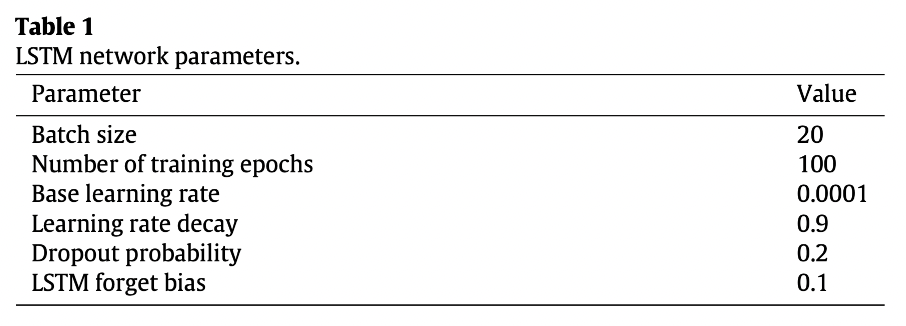

In [11]:
# Split the dataset into train, validation, and test sets
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create DataLoader objects for each dataset
batch_size = 20
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [17]:
# set up hyperparameters
vocab_size = len(tokenizer.word_index) + 1  # add 1 for the 0 padding token
d_model = 32
num_layers = 1
dropout = 0.2
lr = 5e-5

# create model
model = LSTM(vocab_size, d_model, d_model, vocab_size, num_layers, True, dropout)

# set up optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# set up loss function
criterion = nn.CrossEntropyLoss()

In [13]:
model

LSTM(
  (embedding): Embedding(1014, 32)
  (lstm): LSTM(32, 32, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=64, out_features=1014, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [18]:
# train the model
def train(model, iterator, optimizer, criterion):
    train_loss = 0
    train_acc = 0
    model.train()
    for _, batch in enumerate(iterator):
        optimizer.zero_grad()
        text, targets = batch
        text_lengths = [len(x) for x in text]
        predictions = model(text, text_lengths) # gives probs for each token in vocab.
        loss = criterion(predictions, targets) # you will not use argmax here, you should provide the predictions with a vocab_size lenght. 
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += torch.sum(torch.argmax(predictions, dim=1) == targets).item() / targets.shape[0]
    loss = train_loss / len(iterator)
    acc = train_acc / len(iterator)
    return loss, acc

def evaluate(val_loader, model, criterion):
    # validate the model
    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for text, targets in val_loader:
            text_lengths = [len(x) for x in text]
            predictions = model(text, text_lengths)
            loss = criterion(predictions, targets)
            val_loss += loss.item()
            val_acc += torch.sum(torch.argmax(predictions, dim=1) == targets).item() / targets.shape[0]
        val_loss = val_loss / len(val_loader)
        val_acc = val_acc / len(val_loader)
    return val_loss, val_acc
            

epochs = 100
val_loss_lst = []
val_acc_lst = []
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    print(f"Epoch: {epoch+1:02} | Loss: {train_loss:.3f} | Acc: {train_acc*100:.2f}%")
    val_loss, val_acc = evaluate(val_loader, model, criterion)
    val_loss_lst.append(val_loss)
    val_acc_lst.append(val_acc)
    print(f"Epoch: {epoch+1:02} | Val Loss: {val_loss:.3f} | Val Acc: {val_acc*100:.2f}%")
    print("------------------------------------------------")
    

Epoch: 01 | Loss: 6.879 | Acc: 0.29%
Epoch: 01 | Val Loss: 6.830 | Val Acc: 1.21%
------------------------------------------------
Epoch: 02 | Loss: 6.782 | Acc: 3.39%
Epoch: 02 | Val Loss: 6.713 | Val Acc: 10.52%
------------------------------------------------
Epoch: 03 | Loss: 6.637 | Acc: 11.03%
Epoch: 03 | Val Loss: 6.515 | Val Acc: 11.55%
------------------------------------------------
Epoch: 04 | Loss: 6.387 | Acc: 12.93%
Epoch: 04 | Val Loss: 6.180 | Val Acc: 11.90%
------------------------------------------------
Epoch: 05 | Loss: 5.989 | Acc: 13.05%
Epoch: 05 | Val Loss: 5.743 | Val Acc: 14.14%
------------------------------------------------
Epoch: 06 | Loss: 5.525 | Acc: 14.31%
Epoch: 06 | Val Loss: 5.274 | Val Acc: 15.69%
------------------------------------------------
Epoch: 07 | Loss: 5.075 | Acc: 13.28%
Epoch: 07 | Val Loss: 4.826 | Val Acc: 15.69%
------------------------------------------------
Epoch: 08 | Loss: 4.653 | Acc: 13.97%
Epoch: 08 | Val Loss: 4.406 | Val 

In [20]:
# save the val_loss and val_acc as dictionary
import json
val_loss_acc = {"val_loss": val_loss_lst, "val_acc": val_acc_lst}
with open ("saved_files/test", "w") as f:
    json.dump(val_loss_acc, f)

In [91]:
# plot val_acc and val_loss
#import matplotlib.pyplot as plt
#mport numpy as np
# there is something wrong with the vscode for plotting, I will fix it later.

import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")

plt.figure(figsize=(10, 5))
plt.plot(val_loss_lst, label="val_loss")
plt.plot(val_acc_lst, label="val_acc")
plt.legend()
plt.show()

TypeError: 'NoneType' object is not callable

In [68]:
for text, targets in train_loader:
    count=0
    text_lengths = [len(x) for x in text]
    predictions = model(text, text_lengths)
    print(torch.argmax(predictions, dim=1))
    print(targets)
    count+=1
    if count == 10:
        break

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([ 3,  3,  3,  6, 29,  1,  2,  7,  2,  3,  4,  6,  3,  2, 16,  3,  3,  4,
        12,  4])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([  8,   1,   2,   2,   4, 178,  10,   3,   4,  10,   2,   8,   7,   6,
          7,   4,   6,   2,   9,   4])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([ 1,  7, 12,  9, 11,  2, 11,  3,  7,  4,  1,  6,  3,  2,  1, 12,  3,  8,
         3,  4])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([10,  1,  8,  8, 29,  3,  6, 12,  1,  6,  7,  7,  6,  6, 12,  9,  1,  3,
         3,  8])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([29,  3,  4,  2,  6,  1,  3,  2,  2,  7,  1, 11,  7,  2,  9,  8,  7, 14,
         4, 11])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([  4,   4,   3,   2,  16,  10,   1,   4,   4,  12, 178,   8,   1,   2,
   

## Create LSTM Net

In [18]:
import torch 
import torch.nn as nn

vocab_size = len(set([alarm for sequence in alarm_sequence_lst for alarm in sequence]))

config = {
    "vocab_size": vocab_size,
    "embedding_dim": 128,
    "hidden_dim": 256,
    "output_dim": 1,
    "n_layers": 2,
    "bidirectional": True,
    "dropout": 0.0
}

class LSTM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embedding = nn.Embedding(vocab_size, config["embedding_dim"])
        self.lstm = nn.LSTM(config["embedding_dim"], config["hidden_dim"], num_layers=config["n_layers"], bidirectional=config["bidirectional"], dropout=config["dropout"], batch_first=True)
        self.fc = nn.Linear(config["hidden_dim"] * 2 if config["bidirectional"] else config["hidden_dim"], config["output_dim"])
        self.dropout = nn.Dropout(config["dropout"])
        
    def forward(self, text, text_lengths):
        """_summary_

        Args:
            text (_type_): text is a tensor of size [batch_size, sent_length].
            text_lengths (_type_): text_lengths is a tensor of size [batch_size].

        Returns:
            _type_: _description_
        """
        embedded = self.dropout(self.embedding(text))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, batch_first=True)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        return self.fc(hidden.squeeze(0))

In [19]:
lstm = LSTM(config)
lstm

LSTM(
  (embedding): Embedding(39, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [1]:
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
import torch.utils.data as data

class CustomDataset(data.Dataset):
    def __init__(self, df, max_seq_len):
        """Custom Dataset Class

        Args:
            data_path (string): the path we want to import the data from
        """
        super().__init__()
        self.max_seq_len = max_seq_len
        self.df = df
        self.tokenizer = Tokenizer() # tf tokenizer
        self.padded_sequences, self.vocab_size = self.tokenize_and_pad_alarms(self.tokenizer, self.df)
        self.inputs, self.targets = self.create_target_dataset(self.padded_sequences, max_seq_len=max_seq_len-1)

    def tokenize_and_pad_alarms(self,tokenizer, df):
        #tokenizer.fit_on_texts(self.df.values.ravel())
        #vocab_size = len(tokenizer.word_index) + 1
        #vocab_size = len(set(df.values)) # this is only for formula, uncomment above and delete this for others.
        sequences = tokenizer.texts_to_sequences(df.values.ravel())
        padded_sequences = pad_sequences(sequences, maxlen=self.max_seq_len, padding ="post", truncating = "post")
        return padded_sequences, vocab_size

    def create_target_dataset(self, encoded_sequences, max_seq_len):
        inputs = []
        targets = []
        for seq in encoded_sequences:
            for i in range(len(seq) - max_seq_len):
                inputs.append(seq[i:i+max_seq_len])
                targets.append(seq[i+1:i+max_seq_len+1]) # in order to get only the last value, change the index to i+max_seq_len
        inputs = torch.tensor(inputs).long()
        targets = torch.tensor(targets).long()
        return inputs, targets
    
    def create_sequences_from_df_column(self, df, seq_len):
        alarm_lst = []
        for iter in range(num_iter):
            seq = df["alarms"].values[seq_len*iter : seq_len*(iter+1)]
            alarm_lst.append(seq)
        return alarm_lst

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.df.shape[0]

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        inputs = self.inputs[idx]
        targets = self.targets[idx]
        return inputs, targets

In [34]:
dataset = CustomDataset(df, max_seq_len=50)

/var/folders/34/1qrznjy966vdc3s1xrx1qb500000gn/T/ipykernel_6610/3080911807.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  inputs = torch.tensor(inputs).long()


In [35]:
# split the dataset into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = data.random_split(dataset, [train_size, test_size])

In [36]:
# create the dataloaders
train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=32, shuffle=True)

for inputs, targets in train_loader: # full of zeros, something wrong
    print(inputs)
    print(targets.shape)
    break

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
torch.Size([32, 49])


In [37]:
# train the model
from sklearn.metrics import accuracy_score

optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
model = LSTM(config)

# train the model
def train(model, iterator, optimizer, criterion):
    train_loss = 0
    train_acc = 0
    model.train()
    for _, batch in enumerate(iterator):
        optimizer.zero_grad()
        text, targets = batch
        text_lengths = [len(x) for x in text]
        predictions = model(text, text_lengths) # gives probs for each token in vocab.
        loss = criterion(predictions, torch.argmax(targets, dim=1)) # you will not use argmax here, you should provide the predictions with a vocab_size lenght. 
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += torch.sum(torch.argmax(predictions, dim=1) == targets).item() / targets.shape[0]
    loss = train_loss / len(iterator)
    acc = train_acc / len(iterator)
    return loss, acc

def evaluate(val_loader, model, criterion):
    # validate the model
    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for text, targets in val_loader:
            text_lengths = [len(x) for x in text]
            predictions = model(text, text_lengths)
            loss = criterion(predictions, targets.view(-1))
            val_loss += loss.item()
            val_acc += torch.sum(torch.argmax(predictions, dim=1) == targets).item() / targets.shape[0]
        val_loss = val_loss / len(val_loader)
        val_acc = val_acc / len(val_loader)
    return val_loss, val_acc
            

epochs = 10
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    print(f"Epoch: {epoch+1:02} | Loss: {train_loss:.3f} | Acc: {train_acc*100:.2f}%")
    val_loss, val_acc = evaluate(test_loader, model, criterion)
    print(f"Epoch: {epoch+1:02} | Val Loss: {val_loss:.3f} | Val Acc: {val_acc*100:.2f}%")
    print("------------------------------------------------")
    

TypeError: 'NoneType' object is not callable

# Use classes from Waris's thesis for preprocessing

In [3]:
import pandas as pd
from datetime import timedelta
from functools import partial
import itertools
from multiprocessing import Pool

In [4]:
class AlarmProcess():
    def __init__(self, config):
        self.config = config

    def extract_text_before_pv(self, message):
        text_before_pv = message.split("PV")[0].strip()
        return text_before_pv

    def SequenceSegmentation(self,df,seq_duration_gap,filter_short_seq):
        """
        This function segments the alarm sequence according to the time_delta.
        df: dataframe
        seq_duration_gap: time delta in seconds
        filter_short_seq: filter short sequences
        Returns: list of lists (alarms seperated by time_delta)
        """
        print(f">> Duration to next seq: {seq_duration_gap}, ignore seq len: {filter_short_seq}")

        df['Text_Before_PV'] = df['Message'].apply(self.extract_text_before_pv) # extract text before PV

        list_of_sequences = []    
        alarms= df.sort_values(by='StartTime', ascending=True).reset_index(drop=True).to_dict(orient="records")
        alarms = [alarm for alarm in sorted(alarms, key=lambda arg: arg["StartTime"], reverse=False)] # sorting

        # print('check',len(alarms))
        assert alarms[0]['StartTime'] < alarms[-1]['StartTime']
        i =0
        j= 0

        max_seq_len = -1
        while i <len(alarms):
            prev_start = alarms[i]["StartTime"]
            seq = []
            seq.append(alarms[i])
            j = i+1
            while j < len(alarms):    
                next_start = alarms[j]["StartTime"]
                delta = timedelta.total_seconds(next_start - prev_start)
                # print(delta)
                assert delta >= 0
                if delta >= seq_duration_gap:
                    break

                seq.append(alarms[j])
                j += 1
            i = j

            if len(seq) > max_seq_len:
                max_seq_len = len(seq)
            
            if len(seq)>=filter_short_seq: # filter short sequences
                seq = [alarm for alarm in sorted(seq, key=lambda arg: arg["StartTime"], reverse=False)]
                seq = [alarm["Text_Before_PV"] for alarm in seq]
                list_of_sequences.append(seq)
        
        
        return list_of_sequences, max_seq_len
    
    def __removeChatteringAlarmsHelper(self, alarms,chattering_timedelta_threshold, chattering_count_threshold):
        """Find the chatterings in an alarms list from the same source.  
        """

        alarms_without_chattering = []
        alarms = [alarm for alarm in sorted(alarms, key=lambda arg: arg["StartTime"], reverse=False)]
        i = 0
        j = 0

        while i < (len(alarms)):
            alarms_without_chattering.append(alarms[i])
            prev_start = alarms[i]["StartTime"]
            prev_end = alarms[i]["EndTime"]
            count_alarms = 0
            j = i + 1
            while j < len(alarms):
                next_start = alarms[j]["StartTime"]
                next_end = alarms[j]["EndTime"]

                # this assert is very important: the prev alarm has to turn off before the start of
                # the next one
                assert(prev_start <= next_start)
                assert(prev_end <= next_start)
                assert(prev_end <= next_end)

                delta = timedelta.total_seconds(next_start - prev_start)
                assert (delta >= 0)
                
                if delta > chattering_timedelta_threshold:
                    break
                count_alarms += 1
                
                j += 1
            
            if count_alarms >= chattering_count_threshold:
                i = j
            else:
                i += 1

        return alarms_without_chattering
    
    def tempFun(self, df,chat_delta,chat_count,sname):

        alarms_without_chatterings = []
        df_source = df.loc[df['SourceName'].isin([sname])]

        for condition in df_source["Condition"].unique():
            df_condition = df_source.loc[df_source['Condition'].isin([condition])]
            alarms = self.__removeChatteringAlarmsHelper(df_condition.to_dict(orient="records"),chattering_timedelta_threshold=chat_delta,chattering_count_threshold=chat_count)
            alarms_without_chatterings = alarms_without_chatterings + alarms
        
        return alarms_without_chatterings
    
    def removeChatteringAlarms(self, df,chattering_timedelta_threshold=None,chat_count=None):

        # for sname in df["SourceName"].unique():

        alarms_without_chatterings = [] 
        sources=[sname for sname in df["SourceName"].unique()] 

        myFun =  partial(self.tempFun,df,chattering_timedelta_threshold,chat_count)
        

        with Pool(3) as p:
            alarms_without_chatterings = p.map(myFun, sources)

        alarms_without_chatterings = list(itertools.chain.from_iterable(alarms_without_chatterings))
        return pd.DataFrame(alarms_without_chatterings)

In [5]:
data_path = "data/final-all-months-alarms-with-day-filtered.csv"
df = pd.read_csv(data_path)

In [6]:
config = {}

In [7]:
# process after converting dates to datetime
alarm_process = AlarmProcess(config)

In [6]:
#df_chattering_filter = alarm_process.removeChatteringAlarms(df,chattering_timedelta_threshold=60,chat_count=3)
# lets keep chattering alarms problem for now

- First do the chattering alarm filtering and then apply segmentation

In [8]:
df["StartTime"] = pd.to_datetime(df["StartTime"])
df["EndTime"] = pd.to_datetime(df["EndTime"])

In [9]:
# takes about 7 minutes
list_of_sequences, max_seq_len = alarm_process.SequenceSegmentation(df,seq_duration_gap=10,filter_short_seq=2)

>> Duration to next seq: 10, ignore seq len: 2


In [10]:
max_seq_len, len(list_of_sequences), list_of_sequences[0]

(53,
 2390314,
 ['48TIC2027 E209 CIKIS REJEN DRAM', "48FIX2040 C206'DAN C4'E A.GAZ C"])

In [11]:
unique_alarms = set([alarm for seq in list_of_sequences for alarm in seq]) # there are 1121 unique alarms

- There is a problem with the Time Delta value but lets figure it out later. Now I have the alarm sequences I will insert into the model. Lets create the word embedding first.

In [12]:
# word2vec word embedding
from gensim.models import Word2Vec # this is not a pretrained model

In [19]:
word2vec2 = Word2Vec()

In [39]:
# create the model
word2vec = Word2Vec(list_of_sequences, min_count=1, vector_size=100, window=5, sg=1)

{'48TIC2026 E208 CKS TEMIZ MDEA': 0,
 '47TI931A C5 1.YTK GIRDISCAP SICAK': 1,
 '47FLI-032 C-109 MERDIV': 2,
 '48PAL007-ANN INS. DÃ\x83Â\x9cS Y. HAVASI BAS ALM': 3,
 '47TI003A G-3 GOVDE SICAKLIGI': 4,
 "48FIX2040 C206'DAN C4'E A.GAZ C": 5,
 '48TIC2027 E209 CIKIS REJEN DRAM': 6,
 '47TAL003AB-ANN G-3 EMIS SICAKLIGI ALM': 7,
 '47TI002C G-2 B EMIS SICAKLIGI': 8,
 '48PAL007-ANN INS. DÃ\x9cS Y. HAVASI BAS ALM': 9,
 '47TI003B G-3 GOVDE SICAK.': 10,
 '47FIC034 F-1 TOTAL YAKIT KONT.': 11,
 '47TI1713': 12,
 '47PDI1746 E-134 FARK BASINC': 13,
 '48PI2025 K-201 BLOWEREMIS': 14,
 '47FLI-039 C-116/C-117 C-119 PLATF': 15,
 '47PI1734': 16,
 '47AI1503 F-101 OKSIJEN': 17,
 '47LAHH2003-1X-AN 47C211 COK YUKSEK SEV SW ARIZA ALM': 18,
 '47TI870A 47GM-2A U TEMP A': 19,
 '47FI1575 D109 50# STIM': 20,
 '47USI802 47K-2C CYLINDER LUB OIL': 21,
 '47LI900C 47G-2 LUBE OIL TANK LEVE': 22,
 '47PIC1755 D-107 KBS GIRIS BAS': 23,
 'SIO-18XA001': 24,
 '47FI1568 D107 GIRIS KBS AKIMI': 25,
 '47PI010 C-4 GIRIS BASINCI': 26,
 

In [42]:
word2vec.wv.index_to_key

['48TIC2026 E208 CKS TEMIZ MDEA',
 '47TI931A C5 1.YTK GIRDISCAP SICAK',
 '47FLI-032 C-109 MERDIV',
 '48PAL007-ANN INS. DÃ\x83Â\x9cS Y. HAVASI BAS ALM',
 '47TI003A G-3 GOVDE SICAKLIGI',
 "48FIX2040 C206'DAN C4'E A.GAZ C",
 '48TIC2027 E209 CIKIS REJEN DRAM',
 '47TAL003AB-ANN G-3 EMIS SICAKLIGI ALM',
 '47TI002C G-2 B EMIS SICAKLIGI',
 '48PAL007-ANN INS. DÃ\x9cS Y. HAVASI BAS ALM',
 '47TI003B G-3 GOVDE SICAK.',
 '47FIC034 F-1 TOTAL YAKIT KONT.',
 '47TI1713',
 '47PDI1746 E-134 FARK BASINC',
 '48PI2025 K-201 BLOWEREMIS',
 '47FLI-039 C-116/C-117 C-119 PLATF',
 '47PI1734',
 '47AI1503 F-101 OKSIJEN',
 '47LAHH2003-1X-AN 47C211 COK YUKSEK SEV SW ARIZA ALM',
 '47TI870A 47GM-2A U TEMP A',
 '47FI1575 D109 50# STIM',
 '47USI802 47K-2C CYLINDER LUB OIL',
 '47LI900C 47G-2 LUBE OIL TANK LEVE',
 '47PIC1755 D-107 KBS GIRIS BAS',
 'SIO-18XA001',
 '47FI1568 D107 GIRIS KBS AKIMI',
 '47PI010 C-4 GIRIS BASINCI',
 '47LI850C 47G2 LUBE OIL TANK LEV C',
 '47TAL002CD-ANN G-2 B DUSUK GOVDE SIC ALM',
 '47LI608 47D-25

In [13]:
unique_alarms

{'47XL009-ANN G-10A STATUS ALM',
 '47LAL700-ANN K-2 SOGUTMA SUYU TANKI ALM',
 '47FD-039H-AN C-116/C-117 ALEV YUK ALM',
 '47TI443 E-1 CIKIS RESAYKIL GAZ',
 '47PIC027 C-9 DRAMI BASINC KONT',
 '47XL1545B-AN E-104B STATUS ALM',
 '47LI608 47D-25 LEVEL TRASNMITTER',
 '48UA014-ANN 48K-1 B DURDU ALM',
 '47PDI014 C-5 BASINC FARKI',
 '47TI275 C-6 I. YATAKSICAKLIGI',
 '47PI1734',
 '47XL601-ANN G-20A K1 LUBE OIL STATUS ALM',
 '48FFIC014 F2 YAKMA HAVASI',
 '47HSD-005HH- 47D-306 G310 H2S YUK YUK ALM',
 '47PI851B 47G2A YAGLAMA YAGI PRS B',
 '47TI006 E-4 CIKIS C-101 GIRIS',
 '47XL1510-ANN G-104A STATUS ALM',
 '47HCD-063H-A C-7 ALTI C3H8 YUK ALM',
 '47HID-020HH- K-2C 3.KAD.GIR. H2YUKYUK ALM',
 '47TI060 47K-2C 1.KD 3.EMIS VALF',
 '47TI1523 E-108 GIRIS SICAKLIGI',
 '47MOV1000',
 '47TI850 G-3 ARKA YATAK SICAK.',
 '47FD-072H-AN PSA 9 DRAM ALEV YUK ALM',
 '47HCD-079HH- FIC1503/1504 C3H8 YUKYUK ALM',
 '47FD-075H-AN C-107 TEPE ALEV YUK ALM',
 '47APC_RXN_WD 47RXN APC HABRLSME SORUN ALM',
 '47TI820C KM2C ELK.MO

In [14]:
word2vec.wv.most_similar("47HSD-024HH- K2A/B PLAT H2S YUK YUK ALM")

[('47PAL852-ANN G-2A LUBE OIL PMP CIKIS ALM', 0.9626112580299377),
 ('47TAH430-ANN ALM', 0.9618811011314392),
 ('47PAL850-ANN G-2 A LUBE OIL HEDER ALM', 0.9617853164672852),
 ('47FIC1528 Hv. NAFTA TK', 0.9606096744537354),
 ('47PI851B 47G2A YAGLAMA YAGI PRS B', 0.9595340490341187),
 ('47PI851C 47G2A YAGLAMA YAGI PRS C', 0.9571517705917358),
 ('47TI1763 47E-131 KERO Ã\x87IKIS SIC.', 0.9564509987831116),
 ('G2A TRIP FUP ALM', 0.9563007950782776),
 ('48TI023 C-2 RX CIKIS', 0.956243634223938),
 ('47PI1512BCD 47F-101 CHR HEATER ARC P', 0.9557295441627502)]

In [15]:
# get the word vector
word2vec.wv["47HSD-024HH- K2A/B PLAT H2S YUK YUK ALM"].shape

(100,)

In [15]:
# now create an LSTM model using torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [16]:

# the dataset is ready as list of list of sequences. Create a dataset object
class AlarmDataset(Dataset):
    # max_seq_len is the maximum length of the sequence, do not mix it with inputs and targets
    def __init__(self, list_of_sequences, word2vec, max_seq_len):
        super().__init__()
        self.list_of_sequences = list_of_sequences
        self.word2vec = word2vec
        self.max_seq_len = max_seq_len
        self.input, self.target = self.create_target(list_of_sequences)

    def __len__(self):
        return len(self.list_of_sequences[0])

    def __getitem__(self, idx): # replace the string alarms with word2vec vectors
        seq_input, target = self.input[idx], self.target
        seq_len = len(seq_input)
        seq_input = [self.word2vec.wv[word] for word in seq_input]
        seq_input = torch.tensor(seq_input)
        seq_input = F.pad(seq_input, (0, 0, 0, self.max_seq_len - seq_len), "constant", 0) # pad the sequence with zeros
        return seq_input, target
    
    def create_target(self, list_of_sequences):
        inputs = []
        targets = []
        for seq in list_of_sequences:
            inputs.append(seq[:-1])
            targets.append(seq[-1]) # instead of iteration over the sequence, I am using the last alarm of the sequence as the target
        #inputs = torch.tensor(inputs).long()
        #targets = torch.tensor(targets).long()
        return inputs, targets


dataset = AlarmDataset(list_of_sequences, word2vec, max_seq_len)

train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# create the dataloader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"

# create the LSTM model
class AlarmLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(AlarmLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [17]:
# create the model
model = AlarmLSTM(input_size=100, hidden_size=128, num_layers=2, num_classes=len(unique_alarms)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# train the model
def train(epoch):
    model.train()
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))
            
# test the model
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            output = model(data)
            test_loss += criterion(output, data).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(data.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%")


In [18]:
for epoch in range(1, 10):
    train(epoch)
    test()

/var/folders/34/1qrznjy966vdc3s1xrx1qb500000gn/T/ipykernel_35793/3621626266.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  seq_input = torch.tensor(seq_input)


AttributeError: 'list' object has no attribute 'to'